# Rotation Spectra via Looping

## Load Libraries

In [1]:
from andbro__querrySeismoData import __querrySeismoData
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from pandas import DataFrame, concat, Series, date_range, read_csv
from tqdm import tqdm_notebook
from pathlib import Path

import pickle
import matplotlib.pyplot as plt

In [2]:
!ls "/import/kilauea-data/ROMY/RotationSpectra/data/"

run1_columns.pick		run2_ROMY_V__columns.pick
run1_config.pick		run2_ROMY_V__config.pick
run1_frequency_axis.pick	run2_ROMY_V__frequency_axis.pick
run1_minimal_psd.csv		run2_ROMY_V__minimal_psd.csv
run1_minimum_psd.csv		run2_ROMY_V__minimum_psd.csv
run1_RLAS__columns.pick		run3_RLAS__columns.pick
run1_RLAS__config.pick		run3_RLAS__config.pick
run1_RLAS__frequency_axis.pick	run3_RLAS__frequency_axis.pick
run1_RLAS__minimal_psd.csv	run3_RLAS__minimal_psd.csv
run1_RLAS__minimum_psd.csv	run3_RLAS__minimum_psd.csv
run1_ROMY__columns.pick		run3_ROMYZ__columns.pick
run1_ROMY__config.pick		run3_ROMYZ__config.pick
run1_ROMY__frequency_axis.pick	run3_ROMYZ__frequency_axis.pick
run1_ROMY__minimal_psd.csv	run3_ROMYZ__minimal_psd.csv
run1_ROMY__minimum_psd.csv	run3_ROMYZ__minimum_psd.csv
run2_columns.pick		run4_RLAS__columns.pick
run2_config.pick		run4_RLAS__config.pick
run2_frequency_axis.pick	run4_RLAS__frequency_axis.pick
run2_minimal_psd.csv		run4_RLAS__minimal_psd.csv
run2_minimum_psd.csv		run4

## Configurations

In [3]:
inname = "run2_ROMY_V_"
inpath = "/import/kilauea-data/ROMY/RotationSpectra/data/"

config = pickle.load(open(inpath+inname+"_config.pick", 'rb'))

config['inname'] = inname
config['inpath'] = inpath

In [4]:

# config= {}

# config['date1'] = UTCDateTime("2022-01-01")
# config['date2'] = UTCDateTime("2022-01-20")

# config['seed'] = "BW.ROMY.10.HJZ"
# # config['seed'] = "BW.DROMY..FJZ"
# config['repository'] = "george"

# config['ring'] = "RLAS"

# config['outname'] = "run2"
# config['outpath'] = "/import/kilauea-data/ROMY/RotationSpectra/data/"

# config['inname'] = "run1_RLAS_"
# config['inpath'] = "/import/kilauea-data/ROMY/RotationSpectra/data/"

In [5]:
# config['interval'] = 3600
# config['interval_overlap'] = 50 # in percent
# config['taper'] = 'hanning'
# config['segments'] = 1e2
# config['nperseg'] = 128*config.get('segments')
# config['noverlap'] = 64*config.get('segments')
# config['nfft'] = None
# config['detrend'] = 'constant'
# config['scaling'] = 'density'
# config['onesided'] = True
# config['frequency_limits'] = (0, 30) # in Hz

## Looping 

In [6]:
def __get_data(config):
    '''
    load data and remove response

    VARIABLES:
    '''

    try:
        st0, inv = __querrySeismoData(    
                            seed_id=config.get('seed'),
                            starttime=config.get('tbeg'),
                            endtime=config.get('tend'),
                            repository=config['repository'],
                            path=None,
                            restitute=False,
                            detail=None,
                            )

    except:
        print(f"failed to load")
#         print(f"failed to load {config.get['seed']} {config.get['tbeg']}")
        return None
    
    try:
        st0.remove_response(inventory=inv,output="VEL", zero_mean=True); 
    except:
        print(f"failed to remove response")
#         print(f"failed to remove response {config.get['seed']} {config.get['tbeg']}")
        return None
    
    return st0

In [7]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero
    
    min_psd = zeros(psds.shape[1])
    
    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])
    
    return min_psd

In [8]:
def __get_minimum_psd(psds, f_tmp):
    
    from numpy import median
    
    f_before = f_tmp[0]
    f_tmp[0] = 1e-9
    
    for i, psd in enumerate(psds):
        if i == 0: 
            lowest_value = (psds[0]/f_tmp).sum()
#             lowest_value = median(psds[0]/f_tmp)
            idx = 0

        value = (psd/f_tmp).sum() 
#         value = median(psd/f_tmp)
        
        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i

    f_tmp[0] = f_before      
    
    return psds[idx]

In [9]:
def __save_config(config):
    
    ofile = open(config['outpath']+config['outname']+"_config.pick", 'wb')
    pickle.dump(config, ofile)

    if Path(config['outpath']+config['outname']+"_config.pick").exists():
        print(f"created: {config['outpath']}{config['outname']}_config.pick")

In [10]:
def __write_to_csv(data, text, config):
    
    import csv
    
    opath = config['outpath']
    oname = config['outname']+"_"+text+"_psd.csv"
    
    # open the file in the write mode
    with open(opath+oname, 'w') as file:

        writer = csv.writer(file)
        for row in data:
            writer.writerow(row)
            
    if Path(opath+oname).exists():
        print(f"created: {opath}{oname}")

In [11]:
def __calculate_spectra(st, config, mode='dB'):

    from datetime import datetime
    from pandas import date_range
    from obspy import UTCDateTime
    from scipy.signal import welch
    from numpy import where, array, zeros
    
    def __check_stream(st):
        t1 = str(st[0].stats.starttime)
        t2 = str(st[0].stats.endtime)
        for tr in st:
            if str(tr.stats.starttime) != t1 or str(tr.stats.endtime) != t2:
                print(f"ERROR: mismatch in start or endtime of trace: {tr.stats.id}")
                return
            
    def __make_decibel(array, relative_value):
        return 10*log10(array/relative_value) 
    
    ## check time consistency for all traces
    __check_stream(st)
    
    ## check how many intervals are possible
    if config['interval_overlap'] is None:
        intervals = int((st[0].stats.endtime - st[0].stats.starttime)/config.get('interval'))
        shift = config['interval']
    else:
        shift = int(config.get('interval')*config['interval_overlap']/100)
        intervals = int((st[0].stats.endtime - st[0].stats.starttime)/shift)
    


    ## pre-define psd array
    size_psd = int(config.get('nperseg')/2)+1
    psd = zeros([intervals, size_psd])
    
    if size_psd >= len(st[0].data):
        print(f"ERROR: reduce nperseg or noverlap or segments! {size_psd} > {len(st[0].data)}")
        return
    
    for i, tr in enumerate(st):
        
        # initite variables for while loop
        dt1 = st[0].stats.starttime
        dt2 = st[0].stats.starttime + config['interval']
        n = 0
        
        while dt2 <= st[0].stats.endtime:

            tr_tmp = tr.copy()
            tr_tmp.trim(starttime = UTCDateTime(dt1), endtime=UTCDateTime(dt2))

#             print(n, dt1, dt2, "\n")
            
#             print(config.get('nperseg'), config.get('noverlap'), len(tr_tmp.data))
            
            f, psd0 = welch(  
                        tr_tmp.data, 
                        fs=tr_tmp.stats.sampling_rate, 
                        window=config.get('taper'), 
                        nperseg=config.get('nperseg'), 
                        noverlap=config.get('noverlap'), 
                        nfft=config.get('nfft'), 
                        detrend=config.get('detrend'), 
                        return_onesided=config.get('onesided'), 
                        scaling=config.get('scaling'),
                       )
            psd[n] = psd0
            
            ## adjust variables
            dt1 += shift
            dt2 += shift
            n += 1

            
        if config.get('frequency_limits') is not None:
            f1, f2 = config.get('frequency_limits')[0], config.get('frequency_limits')[1]
            idx1, idx2 = int(where(f <= f1)[0][0]), int(where(f >= f2)[0][0])
            ff = f[idx1:idx2]
            tmp = zeros([intervals, len(ff)])
            for j in range(intervals):
                tmp[j] = psd[j,idx1:idx2]
            psd = tmp

        if mode is not None and mode.lower() == 'db':
            for j in range(intervals):
                psd[j] = __make_decibel(psd[j], abs(max(psd[j])))
   
    return ff, psd

In [12]:
def __loop(config):
    
    days = int((config['date2'] - config['date1'])/86400)+1

    minimum_collection = []
    minimal_collection = []
    columns = []

    for date in tqdm_notebook(date_range(str(config['date1'].date), str(config['date2'].date), days, closed='left')):

        config['tbeg'] = UTCDateTime(date)
        config['tend'] = UTCDateTime(date) + 86400

        st = __get_data(config)

        if st is None or st[0].stats.npts < 1000:
            print(f"skipping {date}")
            continue

        ff, psds = __calculate_spectra(st, config, mode=None)

        minimal_psd = __get_minimal_psd(psds)
        minimal_collection.append(minimal_psd)

        minimum_psd = __get_minimum_psd(psds, ff)
        minimum_collection.append(minimum_psd)

        ## write out column names
        columns.append(str(date)[:10])
        with open(config['outpath']+config['outname']+"_columns.pick", 'wb') as ofile:
            pickle.dump(columns, ofile)

        ## store frequency axis
        with open(config['outpath']+config['outname']+"_frequency_axis.pick", 'wb') as ofile:
            pickle.dump(ff, ofile)


    __write_to_csv(minimal_collection, "minimal", config)
    __write_to_csv(minimum_collection, "minimum", config)

    __save_config(config)

In [13]:
def __load_psds(file, config):

    ## get data to dataframe and transpose and reindex
    df = read_csv(file, index_col=False)
    df = df.transpose()
    df.reset_index(inplace=True)
    # df.dtypes
    # df.mean()

    ## set column names
    try:
        columns = pickle.load(open(f"{config['inpath']}{config['inname']}_columns.pick", 'rb'))
        df.columns = [column.replace("-","") for column in columns]
    except:
        print(" -> Failed to assign column names!")

    ## check for column dublicates
    if len(df.columns.unique()) != len(df.columns):
        print(f" -> removing {len(df.columns)-len(df.columns.unique())} column dublicate(s)!")
        df = df.loc[:,~df.columns.duplicated()]

    count=0
    dates_expected = date_range(config['date1'].date, config['date2'].date, periods=int((config['date2']-config['date1'])/86400)+1)
    for dex in dates_expected:
        dex=str(dex.isoformat()[:10]).replace("-","")
        if not dex in df.columns:
            count+=1
    print(f" -> missing {count} days")
        
        
#     ## convert to list
#     psds = []
#     for col in array(df.columns):
        
#         ## turn non-float series to float objects
#         df[col] = pd.to_numeric(df[col], errors = 'coerce')

#         ## add to psds list
#         psds.append(array(df[col]))
        
    return df

In [14]:
def __get_array_from_dataframe(df):
    
    from pandas import to_numeric
    
    ## convert to list
    psds = []
    for col in array(df.columns):
        
        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

In [15]:
def __remove_noise_psds(df, threshold=1e-13):

    from numpy import delete
    
    l1 = len(df.columns)
    for col in df.columns:
#         print(col, type(col))
        if df[col].astype(float).mean() > threshold:
            df = df.drop(columns=col)
    l2 = len(df.columns)
    print(f" -> removed {l1-l2} columns due to mean thresholds!")
 
    return df

In [16]:
# __loop(config)


In [17]:
## load set of minimum psds
file = f"{config['inpath']}{config['inname']}_minimum_psd.csv"
minimum = __load_psds(file, config)

## load minimal possible psds
file = f"{config['inpath']}{config['inname']}_minimum_psd.csv"
minimal = __load_psds(file, config)

## load frequencies
ff = pickle.load(open(f"{config['inpath']}{config['inname']}_frequency_axis.pick", 'rb'))

 -> missing 25 days
 -> missing 25 days


In [18]:
minimal = __remove_noise_psds(minimal, threshold=1e-18)
minimum = __remove_noise_psds(minimum, threshold=1e-18)

 -> removed 93 columns due to mean thresholds!
 -> removed 93 columns due to mean thresholds!


In [19]:
psds_minimal = __get_array_from_dataframe(minimal)
psds_minimum = __get_array_from_dataframe(minimum)

minimals_minimal = __get_minimal_psd(array(psds_minimal))
minimums_minimum = __get_minimum_psd(array(psds_minimum), ff)

In [20]:
minimal.columns[-1]

'20211231'

## Plotting

In [21]:
def __makeplot_colorlines(ff, psds_minimal, psds_minimum, columns):

    fig, ax = plt.subplots(2,2, figsize=(15,10), sharey=False, sharex=True)

    font = 12

    N = psds_minimum.shape[0]
    colors = plt.cm.rainbow(linspace(0, 1, N))


    for n, psd in enumerate(psds_minimum):
        ax[0][0].loglog(ff, psd, color=colors[n])

    for n, psd in enumerate(psds_minimal):
        ax[0][1].loglog(ff, psd, color=colors[n])

    ## add scatter for colorbar object only
    for n, psd in enumerate(psds_minimal):
        p2 = ax[0][1].scatter(ff[0], psd[0], s=0., c=n, cmap='rainbow', vmin=0, vmax=N)


    ax[0][0].loglog(ff, minimals_minimal, 'k')
    ax[0][1].loglog(ff, minimums_minimum, 'k')

    ax[1][0].loglog(ff, minimals_minimal, 'k')
    ax[1][1].loglog(ff, minimums_minimum, 'k')

    ax[0][0].set_title("Minimal PSD", fontsize=font)
    ax[0][1].set_title("Minimum PSD", fontsize=font)

    ax[1][0].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[1][1].set_xlabel("Frequency (Hz)", fontsize=font)

    ax[1][0].set_ylabel(r"PSD (rad$^2$/s$^2$/$\sqrt{Hz})$", fontsize=font)
    ax[1][0].set_ylabel(r"PSD (rad$^2$/s$^2$/$\sqrt{Hz})$", fontsize=font)

    
    ax[0][0].grid(True, which="both", ls="-", alpha=0.5)
    ax[0][1].grid(True, which="both", ls="-", alpha=0.5)
    ax[1][0].grid(True, which="both", ls="-", alpha=0.5)
    ax[1][1].grid(True, which="both", ls="-", alpha=0.5)
    
    ax[0][0].set_xlim(10**log10(0.001), 10**log10(20))
    ax[0][1].set_xlim(10**log10(0.001), 10**log10(20))

    
    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='horizontal', ax=ax, aspect=50)

    ## redefine ticks of colorbar
    dates = columns
    new_ticks=[]
    for t in cbar.get_ticks(): 
        new_ticks.append(dates.astype(str)[int(t)])
    cbar.ax.set_xticklabels(new_ticks)


    plt.show();
    return fig

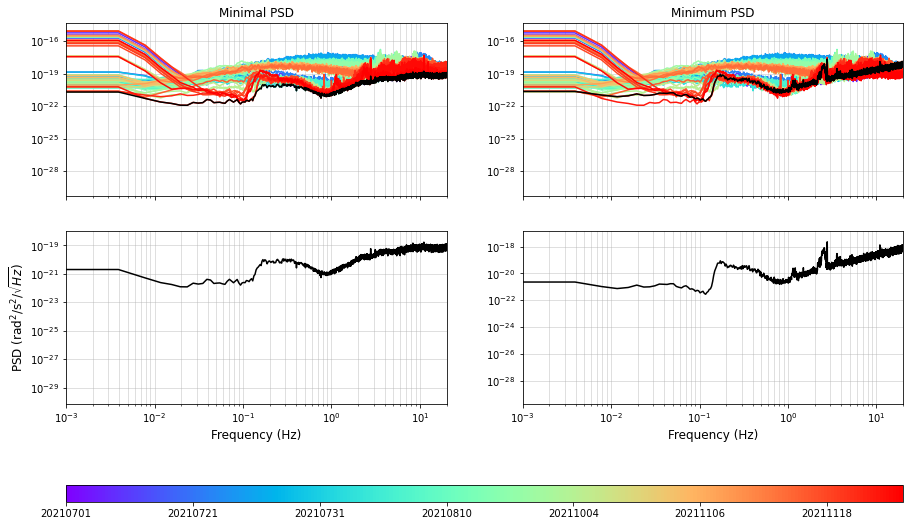

In [22]:
fig = __makeplot_colorlines(ff, psds_minimal, psds_minimum, minimal.columns)

In [23]:
from numpy import logspace, linspace, log, log10

print(psds_minimal.shape)

for i, psd in enumerate(psds_minimal):
#     psds_minimal[i,:] = 10**(psds_minimal[i,:]/10)
    psds_minimal[i,:] = log10(psds_minimal[i,:])
    
for i, psd in enumerate(psds_minimum):
#     psds_minimum[i,:] = 10**(psds_minimum[i,:]/10)
    psds_minimum[i,:] = log10(psds_minimum[i,:])


print(psds_minimal.shape)

(66, 12800)
(66, 12800)


## Calculate and Plot Density

In [24]:
def __calculate_density(psd_array, bins=20):

    from numpy import argmax, std

    max_value = max([max(sublist) for sublist in psd_array])
    min_value = min([min(sublist) for sublist in psd_array])


    dist, dist_maximas, bins_maximas, stds = [], [], [], []

    for h in range(len(psd_array[1])):

        hist, bin_edges = histogram(psd_array[:,h], bins=bins, range=(min_value, max_value), density=None);
        
        bin_mids = 0.5*(bin_edges[1:] + bin_edges[:-1])
        
        dist.append(hist)
        stds.append(std(hist))
        dist_maximas.append(max(hist))
        bins_maximas.append(bin_mids[argmax(hist)])
        
    return array(dist), array(bin_mids), array(bins_maximas), array(stds)

In [25]:
def __makeplot_PPSD(ff, bins, bins_maxima, dist):

    from matplotlib import colors

    # from pandas import Series
    # new = Series(10**edge_maximas).rolling(5, min_periods=1, center=True).mean()
    # edge_maximas = log10(array(new))

    # ff[0] = ff[1]


    y_axis = 10**bins
    x_axis = ff


    ## plotting
    fig = plt.figure(figsize=(10,5))

    font=14

    cmap = plt.cm.get_cmap('magma_r')
    cmap.set_under(color='white')

    im = plt.pcolor(x_axis, y_axis, dist.T, 
                    cmap=cmap,
                    vmin=1e-12, 
    #                 norm=colors.LogNorm(), 
                   )

    plt.plot(x_axis, 10**array(bins_maximas), color='black', alpha=0.5)


    plt.xscale('log')
    plt.yscale('log')

    # plt.ylim(min(y_axis), max(y_axis))
    # plt.xlim(min(x_axis), max(x_axis))

    caxes = fig.add_axes()

    cb = plt.colorbar(im, cax=caxes)
    cb.set_label("counts", fontsize=font)
    
    plt.ylabel(r"PPSD (rad$^2$/s$^2$/$\sqrt{Hz})$", fontsize=font)
    # plt.ylabel(f"PSD (dB rel. to {round(max_value,3)} V$^2$/Hz )",fontsize=font)
    plt.xlabel("Frequency (Hz)",fontsize=font)
    plt.title(f"PPSD {config['ring']} [{config['date1'].date} - {config['date2'].date}]",fontsize=font+2)


    
    plt.tick_params(axis='both', labelsize=font-2)

    plt.show();
    return fig

In [34]:
def __makeplot_model(ff, bins, bins_maxima, stds):

    from matplotlib import colors

    # from pandas import Series
    # new = Series(10**edge_maximas).rolling(5, min_periods=1, center=True).mean()
    # edge_maximas = log10(array(new))

    # ff[0] = ff[1]


    y_axis = 10**bins
    x_axis = ff


    ## plotting
    fig = plt.figure(figsize=(10,5))

    font=14

    plt.plot(x_axis, 10**array(bins_maximas), color='black', alpha=1.)
    
#     plt.plot(x_axis, 10**array(bins_maximas+stds), color='black', alpha=0.5)
#     plt.plot(x_axis, 10**array(bins_maximas-stds), color='black', alpha=0.5)

    plt.fill_between(x_axis, 10**array(bins_maximas-stds**.5),10**array(bins_maximas+stds**0.5), color='grey', alpha=0.7)

    plt.xscale('log')
    plt.yscale('log')

    # plt.ylim(min(y_axis), max(y_axis))
    # plt.xlim(min(x_axis), max(x_axis))

    plt.ylabel(r"PSD (rad$^2$/s$^2$/$\sqrt{Hz})$", fontsize=font)
    plt.xlabel("Frequency (Hz)",fontsize=font)

    plt.xlim(10**log10(0.01), 10**log10(20))
    
    # plt.ylabel(f"PSD (dB rel. to {round(max_value,3)} V$^2$/Hz )",fontsize=font)
    # plt.title(f"Sagnac Spetra on {date.date} ({interval}s windows) ",fontsize=font+2)

    plt.tick_params(axis='both', labelsize=font-2)

    plt.show();
    return fig

## Minimal

In [27]:
dist, bins, bins_maximas, stds = __calculate_density(psds_minimal, bins=100)

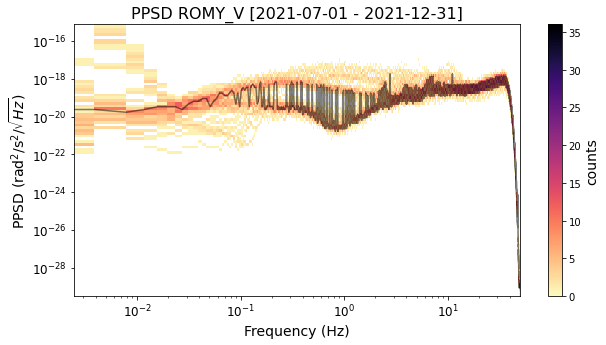

In [35]:
fig = __makeplot_PPSD(ff, bins, bins_maximas, dist)

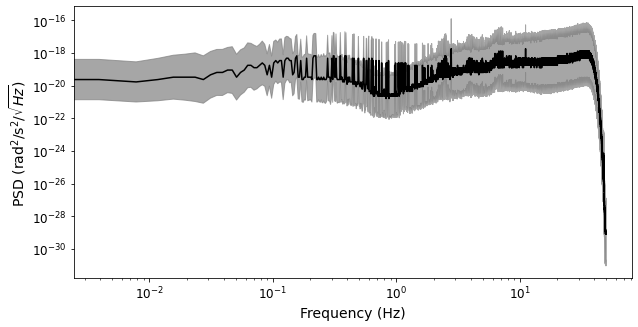

In [29]:
fig = __makeplot_model(ff, bins, bins_maximas, stds)

## Minimum

In [30]:
dist, bins, bins_maximas, stds = __calculate_density(psds_minimum, bins=100)

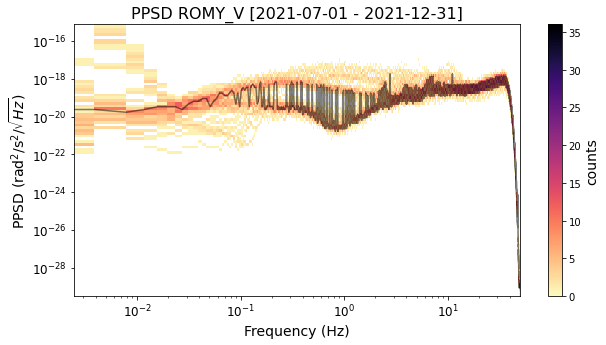

In [31]:
fig = __makeplot_PPSD(ff, bins, bins_maximas, dist)

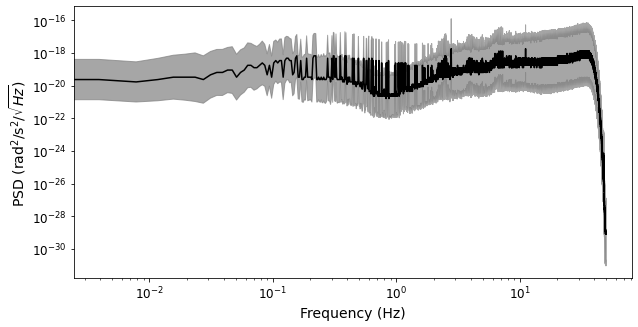

In [32]:
fig = __makeplot_model(ff, bins, bins_maximas, stds)

In [33]:
# fig.savefig(
#             opath+f"plot_sagnacspectra_{date.date}_{interval}_distribution.png", 
#             dpi=300, facecolor='w', 
#             edgecolor='w',
#             orientation='portrait', 
#             format="png",
#             transparent=False, 
#             bbox_inches="tight", 
#             pad_inches=0.2,
#            )